In [1]:
import numpy as np
import patsy
import statsmodels.api as sm
import random
import math
from scipy.integrate import quad, quad_vec
from scipy.stats import norm
import matplotlib.pyplot as plt
from evaluation_non_parametric_function import evaluate_non_parametric

# Exercise 1

In [2]:
knots = [1/4, 2/4, 3/4]
order = 4
x = np.array([i/1001 for i in range(1, 1001)])

In [3]:
bs_basis = patsy.bs(x, degree=order-1, knots=knots, include_intercept=True, lower_bound=0, upper_bound=1)

In [4]:
bs_basis.shape # 1+3+3

(1000, 7)

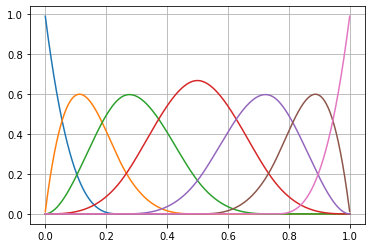

In [5]:
for i in range(7):
    plt.plot(x, bs_basis[:,i])
plt.grid()
plt.show()

In [6]:
basis_matrix = np.ones(shape=(1000,1))
for i in range(1, 4):
    basis_matrix = np.hstack((basis_matrix, np.power(x.reshape((-1,1)), i)))

for i in range(1, 4):
    tmp = x.copy().reshape((-1,1))
    tmp -= i/4
    tmp[tmp < 0] = 0
    tmp = np.power(tmp, order-1)
    basis_matrix = np.hstack((basis_matrix, tmp))

In [7]:
for i in range(bs_basis.shape[-1]):
    model = sm.OLS(bs_basis[:, i], basis_matrix)
    result = model.fit()
    print(result.rsquared)
    # print(result.resid)

1.0
1.0
1.0
1.0
1.0
1.0
1.0


# Exercise 2

## (a)

In [8]:
f2 = lambda x: x*np.sin(20*x)
n2 = 1000
x2 = np.linspace(0, 1, n2)
y2 = f2(x2)
order2 = 4

In [9]:
def fhat2(w, knotlist, y, bx_):
    bx = patsy.bs(x=w, knots=knotlist, degree=3,
                    lower_bound=0, upper_bound=1,
                    include_intercept=True)
        
    coef = sm.OLS(y, bx_).fit().params.reshape((-1, 1))
    ans = bx @ coef
    ans = ans.flatten()
    return ans

def SE2(w):
    return (fhat2(w, knots2, y2, bx_=bx) - f2(w))**2

for i in range(1, 8):
    knots2 = np.arange(1, i+1) / (i+1)

    bx = patsy.bs(x=x, knots=knots2, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    
    ise, _ = quad_vec(SE2, 0, 1)

    print(ise)

[0.15050444]
[0.13040878]
[0.07760046]
[0.05693615]
[0.05900798]
[0.00075183]
[0.00538454]


In [10]:
bx_test = patsy.bs(x=x2, knots=np.arange(1,6+1)/(6+1), degree=3,
                  lower_bound=0, upper_bound=1, include_intercept=True)
print(bx_test.shape)
result_test = sm.OLS(y2, bx_test).fit()
result_test.params

(1000, 10)


array([-0.04708799,  0.12088754,  0.10737875, -0.50095931,  1.03732995,
       -1.60493266,  2.03929649, -2.1104251 ,  0.21291395,  0.99773994])

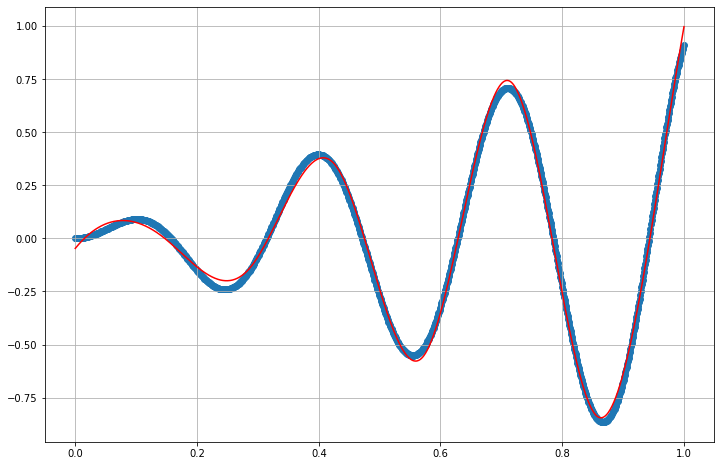

In [11]:
plt.figure(figsize=(12,8))
plt.grid()
plt.scatter(x2, y2)
plt.plot(x2, fhat2(x2, knotlist=np.arange(1,6+1)/(6+1), y=y2,
                  bx_=patsy.bs(x=x2, knots=np.arange(1,6+1)/(6+1), degree=3,
                               lower_bound=0, upper_bound=1,
                               include_intercept=True)
                ),
        c="r"
        )
plt.show()

## (b)

In [12]:
m0 = 11
def pbf_generate(x, m):
    output = np.ones((1000, m+1))
    for i in range(1, m+1):
        output[:, i] = x**(i)
    return output

xm = pbf_generate(x2, m0)
def pbf_hat(w):
    lm_result = sm.OLS(y2, xm).fit()
    x_integrate = pbf_generate(w, m=m0)
    # print(lm_result.params.shape)
    return x_integrate @ lm_result.params

def pbf_SE(w):
    return (pbf_hat(w) - f2(w))**2

In [13]:
quad_vec(pbf_SE, 0, 1)[0][0]

0.0007128775074613914

In [14]:
for m0 in range(1, 13):
    xm = pbf_generate(x2, m0)
    def pbf_hat(w):
        lm_result = sm.OLS(y2, xm).fit()
        x_integrate = pbf_generate(w, m=m0)
        return (x_integrate @ lm_result.params).flatten()
    
    def pbf_SE(w):
        return (pbf_hat(w) - f2(w))**2
    
    ise, _ = quad_vec(pbf_SE, 0, 1)
    print(ise[0])
    m0 += 1

0.1568780887129906
0.15686104563852074
0.15630414982613716
0.14571434506938913
0.1254146032319953
0.09487525806967438
0.07651057313588841
0.0568478102475127
0.011363897332870649
0.010752277218165351
0.0007128775074613914
0.0006947230655092811


# Exercise 3

## (a)

In [15]:
n3 = 1000
x3 = np.linspace(0, 1, n3)
f3 = lambda x: x*np.sin(20*x) # + norm.rvs(scale=0.2) # random.normalvariate(mu=0, sigma=0.2)
e = np.random.randn(n3)*0.2
y3 = f3(x3)
order = 4
deg = order - 1
knots3 = [i/7 for i in range(1, 7)]
m = 3

In [39]:
bx = patsy.bs(x=x3, knots=knots3, degree=deg,
              lower_bound=0, upper_bound=1,
              include_intercept=True)

coef = sm.OLS(y3+e, bx).fit().params

def fhat3(w):
    bx = patsy.bs(x=w, knots=knots3, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef
    return ans

def SE3(w):
    return (fhat3(w) - f3(w))**2

In [41]:
ise_list = []
for i in range(1000):
    np.random.seed(i)
    e = np.random.randn(n3)*0.2
    y3 = f3(x3) + e
    coef = sm.OLS(y3, bx).fit().params
    ise, _ = quad(SE3, 0, 1)
    ise_list.append(ise)

print(sum(ise_list)/1000)

0.0011070367310048635


## (b)

In [18]:
m0 = 11
def pbf_generate(x):
    output = np.ones((n3, m0+1))
    for i in range(1, m0+1):
        output[:, i] = x**(i)
    return output

xm = pbf_generate(x3)
lm_result = sm.OLS(y3+e, xm).fit()
coef = lm_result.params

def pbf_hat(w):
    x_integrate = pbf_generate(x=w)
    output = x_integrate @ coef
    return output

def pbf_SE(w):
    # return (pbf_hat(w) - y3)**2
    return (pbf_hat(w) - f3(w))**2

In [19]:
quad_vec(pbf_SE, 0, 1)[0].mean()

0.0037338811707209123

In [42]:
pbf_list = []
for i in range(1000):
    np.random.seed(i)
    e = np.random.randn(n3)*0.2
    y3 = f3(x3) + e
    coef = sm.OLS(y3, xm).fit().params
    ise, _ = quad_vec(pbf_SE, 0, 1)
    pbf_list.append(ise.mean())

print(sum(pbf_list)/1000)

0.0011928626933623114


# Exercise 4

In [21]:
n4 = 1000
x4 = np.linspace(0, 1, n4)
f4 = lambda x:  x*np.sin(20*x)
# e4 = np.random.randn(n4)*0.2
# y4 = f4(x4)
order = 4
deg = order - 1

In [22]:
k = [1, 2, 3, 4, 5, 6, 7]
m = [i for i in range(1, 13)]
def knots4(k):
    return [i/(k+1) for i in range(1, k+1)]

## (a)

In [23]:
def RSSCV(x, k):
    knot_4 = knots4(k)
    z = patsy.bs(x=x, knots=knot_4, degree=3, include_intercept=True, lower_bound=0, upper_bound=1)
    model = sm.OLS(y4, z)
    result = model.fit()
    fhat = z @ result.params

    h = z @ np.linalg.inv(z.T@z) @ z.T
    hii = np.diag(h)
    return np.sum((y4 - fhat)**2/(1 - hii)**2)

In [24]:
# for i in k:
#     print(f"num of knots {i}: ", RSSCV(x=x4, k=i))

In [25]:
def fhat4(w):
    bx = patsy.bs(x=w, knots=best_knots, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef4a
    return ans

def SE4(w):
    return (fhat4(w) - f4(w))**2

In [26]:
ISE_list = []
for i in range(1000):
    np.random.seed(i)
    e4 = np.random.randn(n4)*0.2
    y4 = f4(x4)
    rsscv_list = []
    for j in range(1, 8):
        rsscv_list.append(RSSCV(x=x4, k=j))
    best_k = rsscv_list.index(min(rsscv_list)) + 1
    best_knots = knots4(best_k)
    bx = patsy.bs(x=x4, knots=best_knots, degree=deg,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    coef4a = sm.OLS(y4+e4, bx).fit().params
    ise, _ = quad(SE4, 0, 1)
    ISE_list.append(ise)

In [27]:
sum(ISE_list) / 1000

0.0011070367310048635

## (b)

In [31]:
def pbf_generate2(x, m):
    output = np.ones((n4, m+1))
    for t in range(1, m+1):
        output[:, t] = x**(t)
    return output

def RSSCV_b(x, m):
    z = pbf_generate2(x=x, m=m)
    model = sm.OLS(y4, z)
    result = model.fit()
    fhat = z @ result.params
    h = z @ np.linalg.inv(z.T@z) @ z.T
    hii = np.diag(h)
    return np.sum((y4 - fhat)**2/(1 - hii)**2)

In [43]:
def pbf_hat4(w):
    xm = pbf_generate2(x=w, m=best_m)
    output = xm @ coef4b
    return output

def pbf_SE4(w):
    return (pbf_hat4(w) - f4(w))**2

In [45]:
ISE_list_b = []
for i in range(1000):
    np.random.seed(i)
    e4 = np.random.randn(n4)*0.2
    y4 = f4(x4) + e4
    rsscv_list_b = []
    for j in range(1, 13):
        rsscv_list_b.append(RSSCV_b(x=x4, m=j))
    best_m = rsscv_list_b.index(min(rsscv_list_b)) + 1
    
    xm4b = pbf_generate2(x4, best_m)
    coef4b = sm.OLS(y4, xm4b).fit().params
    ise, _ = quad_vec(pbf_SE4, 0, 1)
    ISE_list_b.append(ise.mean())
print(sum(ISE_list_b)/1000)

0.0012128791557230742
